# RO reference
Fit RO on observations to get "ground truth" behavior

## Imports

In [1]:
import warnings
import copy
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import pandas as pd
import os
import scipy.stats
import xeofs as xe
import src.lim

# Import custom modules
import src.XRO
import src.XRO_utils
import src.utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## get RNG
rng = np.random.default_rng()

## Load data

In [2]:
## specify filepaths
oras_fp = DATA_FP / "oras5"

## load data
data = src.utils.load_oras_spatial_extended(oras_fp, varnames=["tos", "d20"])

## compute indices
idx_total = src.utils.get_RO_indices(data, h_var="d20")

## compute "wide" hbar
idx_total["h_"] = src.utils.spatial_avg(
    data["d20"].sel(longitude=slice(120, 280), latitude=slice(-15, 15))
)
idx_total["h__"] = src.utils.spatial_avg(
    data["d20"].sel(longitude=slice(120, 210), latitude=slice(-15, 15))
)

## Detrend / pre-process

In [3]:
## estimate forced signal by removing 2nd-order polynomial from each calendar month
detrend_fn = lambda x: src.utils.detrend_dim(x, dim="time", deg=3)
idx = idx_total.groupby("time.month").map(detrend_fn)
idx_forced = idx_total - idx

## standardize for convenience
idx /= idx.std()

## Cross correlation stats

Plotting function

In [4]:
def format_xcorr_ax(ax):
    """make xcorr plot look nice"""

    axis_kwargs = dict(c="k", lw=0.5, alpha=0.5)
    ax.axhline(0, **axis_kwargs)
    ax.axvline(0, **axis_kwargs)
    ax.set_ylim([-0.9, 1.1])
    ax.set_xlabel("Lag (years)")
    ax.set_xticks([-24, -12, 0, 12, 24], labels=[-2, -1, 0, 1, 2])
    ax.set_yticks([-0.5, 0, 0.5, 1])
    ax.set_ylabel("Correlation")
    return

Make the plot

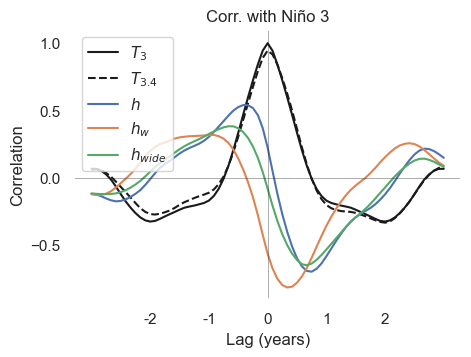

In [5]:
## compute cross-corr
xcorr = src.XRO.xcorr(idx, idx["T_3"], maxlags=36)

## plot result
fig, ax = plt.subplots(figsize=(5, 3.5))

## plot data
ax.plot(xcorr.lag, xcorr["T_3"], label=r"$T_3$", c="k")
ax.plot(xcorr.lag, xcorr["T_34"], label=r"$T_{3.4}$", c="k", ls="--")
ax.plot(xcorr.lag, xcorr["h"], label=r"$h$")
ax.plot(xcorr.lag, xcorr["h_w"], label=r"$h_w$")
ax.plot(xcorr.lag, xcorr["h_"], label=r"$h_{wide}$")

## format plot
ax.set_title("Corr. with Niño 3")
ax.legend()
format_xcorr_ax(ax)

plt.show()

## Fit RO models

In [6]:
## specify order of annual cycle, mask parameters
ac_order = 3
ac_mask_idx = [(1, 1)]  # epsilon
# ac_mask_idx = [(1,0), (1, 1)] # epsilon and F2
# ac_mask_idx = [(0,1),(1,0),(1, 1)] # all except R
# ac_mask_idx = None

## initialize model
model = src.XRO.XRO(ncycle=12, ac_order=ac_order, is_forward=True)

## get fit for reanalysis
fit_h = model.fit_matrix(idx[["T_34", "h"]], ac_mask_idx=ac_mask_idx)
fit_hw = model.fit_matrix(idx[["T_34", "h_"]], ac_mask_idx=ac_mask_idx)

## extract params
p_h = model.get_RO_parameters(fit_h)
p_hw = model.get_RO_parameters(fit_hw)

/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


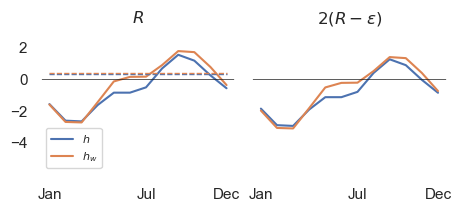

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2), layout="constrained")

for i, (ax, n) in enumerate(zip(axs, ["R", "BJ_ac"])):
    ax.plot(p_h.cycle, p_h[n], label=r"$h$")
    ax.plot(p_hw.cycle, p_hw[n], label=r"$h_w$")

    ## format
    ax.axhline(0, ls="-", c="k", lw=0.5)
    ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])

## plot epsilon values as well
kwargs = dict(lw=1, ls="--")
axs[0].plot(p_h.cycle, p_h["epsilon"], c=sns.color_palette()[0], **kwargs)
axs[0].plot(p_h.cycle, p_hw["epsilon"], c=sns.color_palette()[1], **kwargs)

## label
axs[1].set_yticks([])
axs[0].set_yticks([-4, -2, 0, 2])
axs[0].set_title(r"$R$")
axs[1].set_title(r"$2\left(R-\varepsilon\right)$")
axs[0].legend(prop=dict(size=8))
axs[0].set_ylim([-6, 3])
axs[1].set_ylim(0.5 * np.array(axs[0].get_ylim()))

plt.show()

## check stats 

Generate simulations

In [8]:
## specify random IC
x0 = idx.isel(time=rng.choice(np.arange(len(idx.time))))

## simulation specs
simulation_kwargs = dict(
    nyear=63,
    ncopy=1000,
    is_xi_stdac=False,
)

## do simulations
kwargs_h = dict(simulation_kwargs, fit_ds=fit_h, X0_ds=x0[["T_34", "h"]])
X_h = model.simulate(**kwargs_h)

kwargs_hw = dict(simulation_kwargs, fit_ds=fit_hw, X0_ds=x0[["T_34", "h_"]])
X_hw = model.simulate(**kwargs_hw)

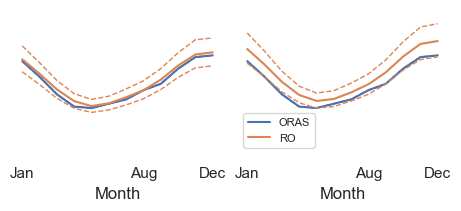

In [9]:
### Set up plot
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2), layout="constrained")

## plot RO with h (early period)
plot_data_early = src.utils.plot_seasonal_comp(
    axs[0],
    x0=idx.expand_dims("member"),
    x1=X_h,
    plot_kwargs0=dict(label="ORAS"),
    plot_kwargs1=dict(label="RO"),
    varname="T_34",
    use_quantile=True,
)

## plot RO with h (early period)
plot_data_early = src.utils.plot_seasonal_comp(
    axs[1],
    x0=idx.expand_dims("member"),
    x1=X_hw,
    plot_kwargs0=dict(label="ORAS"),
    plot_kwargs1=dict(label="RO"),
    varname="T_34",
    use_quantile=True,
)

axs[1].legend(prop=dict(size=8))

for ax in axs:
    ax.set_ylim([0, 2])

plt.show()

## Compute $R$ explicitly

In [10]:
## compute gradients
grads = src.XRO.gradient(src.XRO._convert_to_numpy(idx))

## add to array
for i, n in enumerate(list(idx)):
    idx.update({f"{n}_grad": xr.DataArray(grads[i], coords=dict(time=idx.time))})


def get_stats(T_var, h_var, month):
    """Get statistics needed to compute R"""

    ## indexer
    t_idx = dict(time=idx.time.dt.month == month)

    ## get subset of array
    sel_vars = [T_var, h_var, f"{T_var}_grad", f"{h_var}_grad"]
    names = {
        T_var: "T",
        h_var: "h",
        f"{T_var}_grad": "T_grad",
        f"{h_var}_grad": "h_grad",
    }
    X = idx.isel(t_idx)[sel_vars].rename(names)

    ## compute stats
    sigma_T = np.std(X["T"].values)
    sigma_h = np.std(X["h"].values)
    r = scipy.stats.pearsonr(X["T"].values, X["h"].values)[0]

    ## compute covariance
    TtT = np.mean(X["T_grad"] * X["T"]).values.item() * np.pow(sigma_T, -2)
    Tth = (
        np.mean(X["T_grad"] * X["h"]).values.item()
        * np.pow(sigma_T, -1)
        * np.pow(sigma_h, -1)
    )

    return dict(r=r, TtT=TtT, Tth=Tth)


def get_R(T_var, h_var, month):
    """function to compute estimate of R for given variables and month"""

    ## compute stats
    stats = get_stats(T_var=T_var, h_var=h_var, month=month)
    r = stats["r"]
    TtT = stats["TtT"]
    Tth = stats["Tth"]

    ## compute estimate for R
    Rhat = 1 / (1 - r**2) * (TtT - r * Tth)

    return Rhat

\begin{align}
    R &= \frac{\sigma_T^{-1}}{1-r^2}\left[\left<T_t,\tilde{T}\right> - r\left<T_t,\tilde{h}\right>\right]
\end{align}

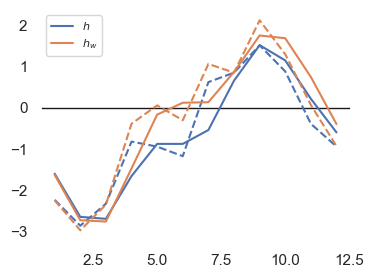

In [11]:
#### compute
## kwargs
kwargs_h = dict(T_var="T_34", h_var="h")
kwargs_hw = dict(T_var="T_34", h_var="h_")

## compute estimates
Rhats_h = np.array([get_R(month=m, **kwargs_h) for m in np.arange(1, 13)])
Rhats_hw = np.array([get_R(month=m, **kwargs_hw) for m in np.arange(1, 13)])


#### plot
colors = sns.color_palette()
fig, ax = plt.subplots(figsize=(4, 3))

## plot first version
ax.plot(p_h.cycle, Rhats_h, c=colors[0], ls="--")
ax.plot(p_h.cycle, p_h["R"], c=colors[0], label=r"$h$")

## plot second version
ax.plot(p_h.cycle, Rhats_hw, c=colors[1], ls="--")
ax.plot(p_h.cycle, p_hw["R"], c=colors[1], label=r"$h_w$")

## label
ax.legend(prop=dict(size=8))
ax.axhline(0, lw=1, c="k", zorder=0.5)

plt.show()

## Scatter plots

Look at relationship between $T_e$ and $\overline{h}-h_w$

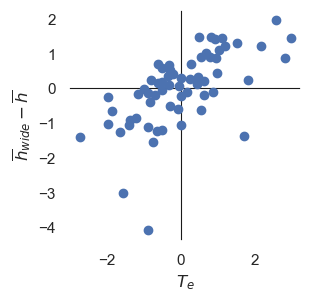

In [12]:
m = 10
t_idx = dict(time=idx.time.dt.month == m)

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(
    # idx["h"].isel(t_idx) - idx["h_w"].isel(t_idx),
    # idx["T_3"].isel(t_idx),
    idx["T_34"].isel(t_idx),
    # idx["h_"].isel(t_idx),# - idx["h"].isel(t_idx),
    idx["h"].isel(t_idx),
    # idx["h_"].isel(t_idx), idx["h"].isel(t_idx)
)


## label
ax.set_ylabel(r"$\overline{h}_{wide} - \overline{h}$")
ax.set_xlabel(r"$T_e$")
kwargs = dict(c="k", lw=0.8, zorder=0.5)
ax.axvline(0, **kwargs)
ax.axhline(0, **kwargs)
plt.show()

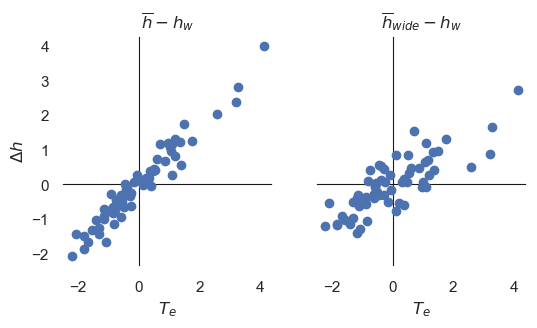

In [13]:
m = 11
t_idx = dict(time=idx.time.dt.month == m)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].scatter(
    idx["T_3"].isel(t_idx),
    idx["h"].isel(t_idx) - idx["h_w"].isel(t_idx),
)

axs[1].scatter(
    idx["T_3"].isel(t_idx),
    idx["h_"].isel(t_idx) - idx["h_w"].isel(t_idx),
)


## label
axs[0].set_ylabel(r"$\Delta h$")
axs[1].set_yticks([])
axs[0].set_title(r"$\overline{h}-h_w$")
axs[1].set_title(r"$\overline{h}_{wide}-h_w$")
kwargs = dict(c="k", lw=0.8, zorder=0.5)
axs[1].set_ylim(axs[0].get_ylim())

for ax in axs:
    ax.axvline(0, **kwargs)
    ax.axhline(0, **kwargs)
    ax.set_xlabel(r"$T_e$")
plt.show()

## Compute EOFs

get detrended data

In [14]:
## get subset of data
data_ = data[["sst", "d20"]].groupby("time.month").map(detrend_fn)
data_ = data_.sel(longitude=slice(120, 280))

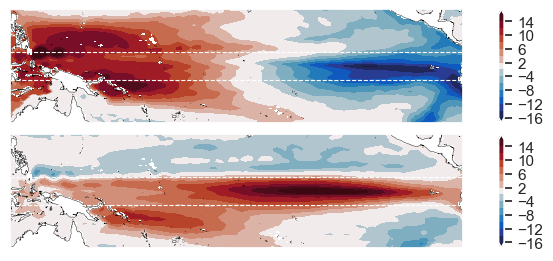

In [15]:
## specify time index for EOFs
t_idx = dict(time=slice(None, None, None))

## fit EOFs
model_d20 = xe.single.EOF(use_coslat=True, n_modes=10)
model_d20.fit(data_["d20"].isel(t_idx), dim="time")

model_sst = xe.single.EOF(use_coslat=True, n_modes=10)
model_sst.fit(data_["sst"].isel(t_idx), dim="time")

## get weights for each mode
s = np.sqrt(model_d20.explained_variance())

## get patterns
patterns = model_d20.components() * s

## plot leading modes
fig = plt.figure(figsize=(8, 2.5), layout="constrained")
axs = src.utils.subplots_with_proj(
    fig, nrows=2, ncols=1, format_func=src.utils.plot_setup_pac
)

## shared arguments for plotting
kwargs = dict(
    cmap="cmo.balance",
    transform=ccrs.PlateCarree(),
    levels=src.utils.make_cb_range(16, 2),
    extend="both",
)

cp = axs[0, 0].contourf(
    patterns.longitude,
    patterns.latitude,
    patterns.isel(mode=0),
    **kwargs,
)
cb = fig.colorbar(cp)

cp = axs[1, 0].contourf(
    patterns.longitude,
    patterns.latitude,
    patterns.isel(mode=1),
    **kwargs,
)
kwargs = dict(ls="--", c="w", lw=0.8)
for ax in axs.flatten():
    ax.set_extent([120, 280, -20, 20], crs=ccrs.PlateCarree())
    ax.axhline(-5, **kwargs)
    ax.axhline(5, **kwargs)

cb = fig.colorbar(cp)

plt.show()

## Look at regression with Niño 3.4 index

/Users/theo/research/enso2025_xro/src/utils.py:1018: RuntimeWarning: Mean of empty slice
  Y = Y - np.nanmean(Y, axis=0)
/Users/theo/research/enso2025_xro/src/utils.py:1022: RuntimeWarning: invalid value encountered in divide
  rho = (x.T @ Y) / np.sqrt(np.sum(Y**2, axis=0) * np.dot(x, x))


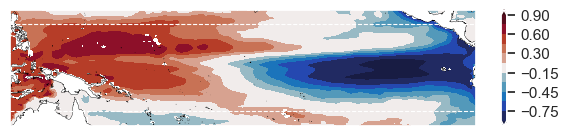

In [16]:
## compute correlation coefs
# coefs = src.utils.ls_fit_xr(Y_data=data_, idx=idx["T_34"]).isel(coef=0)
# coefs = src.utils.rho_xr(Y_data=data_, idx=idx["h_"])
# coefs = src.utils.rho_xr(Y_data=data_["sst"], idx=idx["h_w"])
coefs = src.utils.rho_xr(Y_data=data_["d20"], idx=idx["h"] - idx["h_w"])

## plot leading modes
fig = plt.figure(figsize=(6, 1.25), layout="constrained")
axs = src.utils.subplots_with_proj(
    fig, nrows=1, ncols=1, format_func=src.utils.plot_setup_pac
)

# ## shared arguments for plotting
kwargs = dict(
    cmap="cmo.balance",
    transform=ccrs.PlateCarree(),
    # levels=src.utils.make_cb_range(16, 2),
    levels=src.utils.make_cb_range(0.9, 0.15),
    extend="both",
)

cp = axs[0, 0].contourf(
    coefs.longitude,
    coefs.latitude,
    -coefs,
    **kwargs,
)
cb = fig.colorbar(cp)

kwargs = dict(ls="--", c="w", lw=0.8)
for ax in axs.flatten():
    ax.set_extent([120, 280, -20, 20], crs=ccrs.PlateCarree())
    ax.axhline(-15, **kwargs)
    ax.axhline(15, **kwargs)


# cb = fig.colorbar(cp)

plt.show()

## LIM

#### Put data in correct format

In [17]:
## get weighted data for LIM
get_weight = (
    lambda model: model.explained_variance_ratio().sum()
    * 1
    / np.sqrt(model.explained_variance()[0])
)
get_weighted_scores = lambda model: model.scores() * get_weight(model).values


## reshape
XY_np = np.concatenate(
    [
        get_weighted_scores(model_sst).rename("sst").values,
        get_weighted_scores(model_d20).rename("d20").values,
    ],
    axis=0,
)

## get month labels
month_idx = model_sst.scores().time.dt.month.values - 1

## fit LIM
lim = src.lim.LIM_CS(X=XY_np[:, :-1], Y=XY_np[:, 1:], month_labels=month_idx[:-1])

## get spectrum
sigma = 12 * copy.deepcopy(lim.sigma)
omega = 12 / (2 * np.pi) * copy.deepcopy(lim.omega)

Plot spectrum

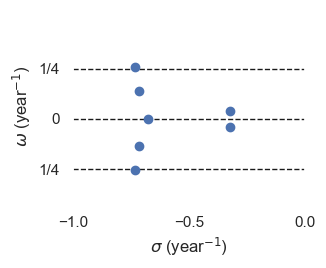

In [18]:
## plot spectrum
fig, ax = plt.subplots(figsize=(3, 2.5))

## plot data
ax.scatter(sigma, omega)

## label / guidelines
kwargs = dict(c="k", zorder=0.5, lw=1, ls="--")
for yt in [-0.25, 0, 0.25]:
    ax.axhline(yt, **kwargs)
ax.set_yticks([-1 / 4, 0, 1 / 4], labels=[r"1/4", "0", "1/4"])
ax.set_xticks([-1, -0.5, 0])
ax.set_xlim([-1, 0])
ax.set_xlabel(r"$\sigma$ (year$^{-1}$)")
ax.set_ylabel(r"$\omega$ (year$^{-1}$)")

plt.show()

#### evaluate eigenfuncs

In [19]:
## specify eigenfunction index for ENSO
enso_idx = 5

## evaluate ENSO eigenfunction
varphi = np.einsum(
    "nm,mn->n",
    lim.V[month_idx, :, enso_idx],
    XY_np,
)